In [38]:
from labeling import Labeling
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# Binance API parameters
traded_assets = ['BTC']#, 'ETH', 'ADA', 'DOGE']
stable_assets = ['USDT']
start_date = "Jan 01, 2021"
end_date = "Dec 31, 2021"
time_horizons = ['12hr']#, '12hr', '1wk']

# EMA parameters
alpha_values = [0.5]

# labeling parameters
trend_reversal_tresholds = []
change_tolerances = []
forward_terms = []



In [31]:
for traded_asset in traded_assets:
    for stable_asset in stable_assets:
        for time_horizon in time_horizons:
            for alpha_value in alpha_values:
                df = pd.read_csv(f"data/{traded_asset}_{stable_asset}_{time_horizon}_{alpha_value}_ema.csv")

                df_labeled = Labeling(
                    df = df,
                    alpha = 0.5,
                    trend_reverse_factor = 0.3,
                    change_tolerance = 1,
                    forward_term = 10,
                    break_away_point = 2
                )

                df = df_labeled.label_long_utility()

                df.to_csv(f'data/labeled/{traded_asset}_{stable_asset}_{time_horizon}_{alpha_value}_long_utility_labeled.csv')

In [32]:
df

,open,close,closeTime,close_ema,close_time_parsed
0,28923.63,29313.49,1609502399999,29313.490000,2021-01-01 11:59:59
1,29313.49,29331.69,1609545599999,29325.623333,2021-01-01 23:59:59
2,29331.70,29755.00,1609588799999,29570.981429,2021-01-02 11:59:59
3,29754.99,32178.33,1609631999999,30961.567333,2021-01-02 23:59:59
4,32176.45,34413.53,1609675199999,32743.225484,2021-01-03 11:59:59
...,...,...,...,...,...
724,47543.74,47737.95,1640779199999,48236.703880,2021-12-29 11:59:59
725,47737.96,46464.66,1640822399999,47350.681940,2021-12-29 23:59:59
726,46464.66,47515.45,1640865599999,47433.065970,2021-12-30 11:59:59
727,47515.45,47120.87,1640908799999,47276.967985,2021-12-30 23:59:59


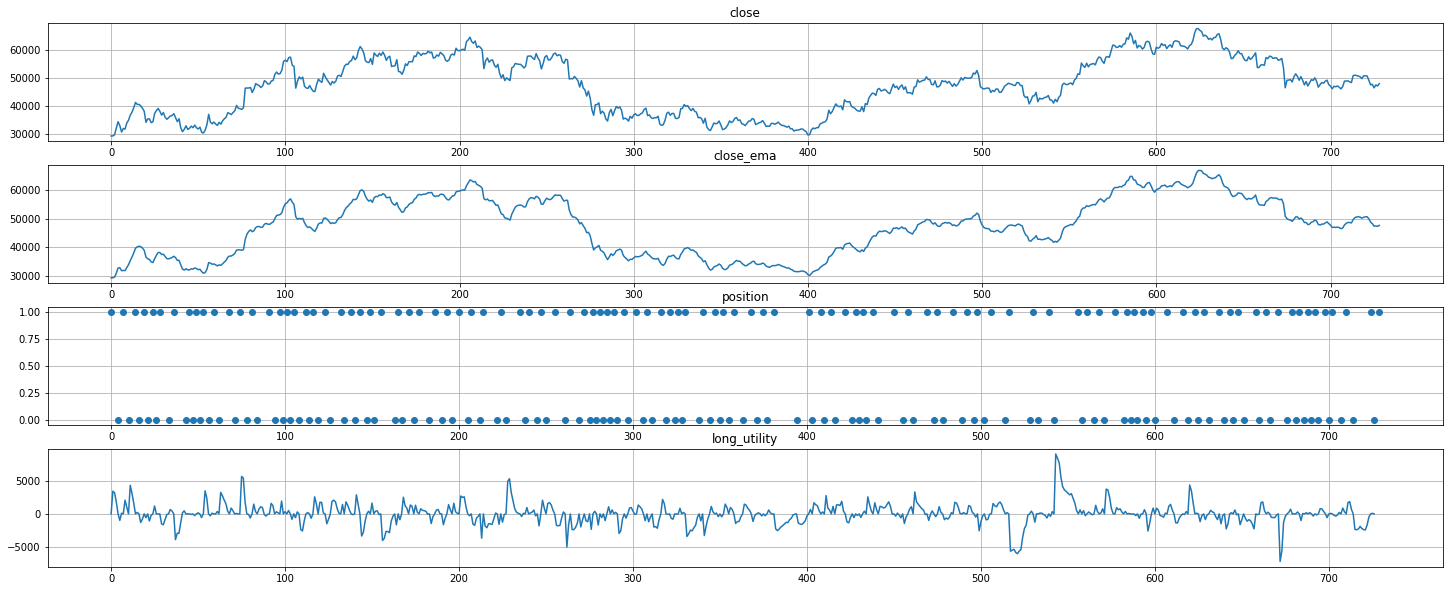

In [37]:
plt.figure(figsize=(25, 10))
plt.subplot(411)
plt.plot(df['close'])
plt.title('close')
plt.grid()

plt.subplot(412)
plt.plot(df['close_ema'])
plt.title('close_ema')
plt.grid()

plt.subplot(413)
plt.plot(df['position'], 'o')
plt.title('position')
plt.grid()

plt.subplot(414)
plt.plot(df['long_utility'])
plt.title('long_utility')
plt.grid()